# Clustering for roaming data
Direct business, 2024, Handsets only

## 1.EDA

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

In [2]:
df=pd.read_csv('roaming2024_direct.csv')
df.shape

(20712, 11)

In [3]:
df

,Segment,Satcode,RoamingZone,SubsVol,RevenueTotal,DataUsage,OutboundCalls,OutboundMinutes,InboundCalls,InboundMinutes,SmsVol
0,ENTERPRISE,DG_CORINS,Zone 1 Europe,108,60.95,63170.444,576.0,113236.0,515.0,41189.0,176.0
1,SMB - MidMarket,DG_PFWHIT,Zone 1 Europe,65,0.79,300044.253,448.0,45512.0,668.0,28093.0,92.0
2,SMB - MidMarket,DG_STONPL,Zone 1 Europe,13,1.20,49976.262,225.0,40171.0,176.0,13947.0,29.0
3,ENTERPRISE,DG_BUNZL,Zone 3 Value,396,524.08,261443.577,1058.0,255303.0,641.0,116376.0,983.0
4,SMB - MidMarket,DG_CNASER,Zone 1 Europe,256,151.00,112806.035,343.0,48868.0,732.0,14243.0,49.0
...,...,...,...,...,...,...,...,...,...,...,...
20707,SMB - MidMarket,DG_WOMA,Zone 3 Value,1,0.00,1078.268,30.0,6625.0,9.0,3292.0,1.0
20708,SMB - MidMarket,DG_ZETAG,Zone 1 Europe,38,0.00,128806.549,30.0,3504.0,81.0,2013.0,30.0
20709,SMB - MidMarket,DG_SCAPE,Zone 1 Europe,15,0.00,22038.263,30.0,3757.0,50.0,2512.0,8.0
20710,SMB - MidMarket,DG_WESGL,Zone 1 Europe,3,0.00,4512.608,30.0,4582.0,27.0,1896.0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20712 entries, 0 to 20711
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Segment          20712 non-null  object 
 1   Satcode          20709 non-null  object 
 2   RoamingZone      20712 non-null  object 
 3   SubsVol          20712 non-null  int64  
 4   RevenueTotal     20712 non-null  float64
 5   DataUsage        20712 non-null  float64
 6   OutboundCalls    20712 non-null  float64
 7   OutboundMinutes  20712 non-null  float64
 8   InboundCalls     20712 non-null  float64
 9   InboundMinutes   20712 non-null  float64
 10  SmsVol           20712 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 1.7+ MB


In [5]:
print(df['Satcode'].isnull().sum())
print(df['Satcode'].isna().sum())

3
3


### !!! 3 records having nulls for Satcode, I'll drop them as we have enough observations

In [6]:
df.dropna(inplace=True)
df.shape

(20709, 11)

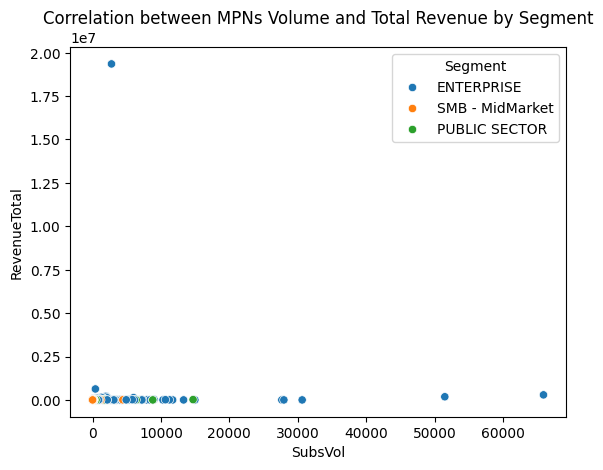

In [7]:
sns.scatterplot(df,x='SubsVol', y='RevenueTotal', hue='Segment')
plt.title('Correlation between MPNs Volume and Total Revenue by Segment')
plt.show()

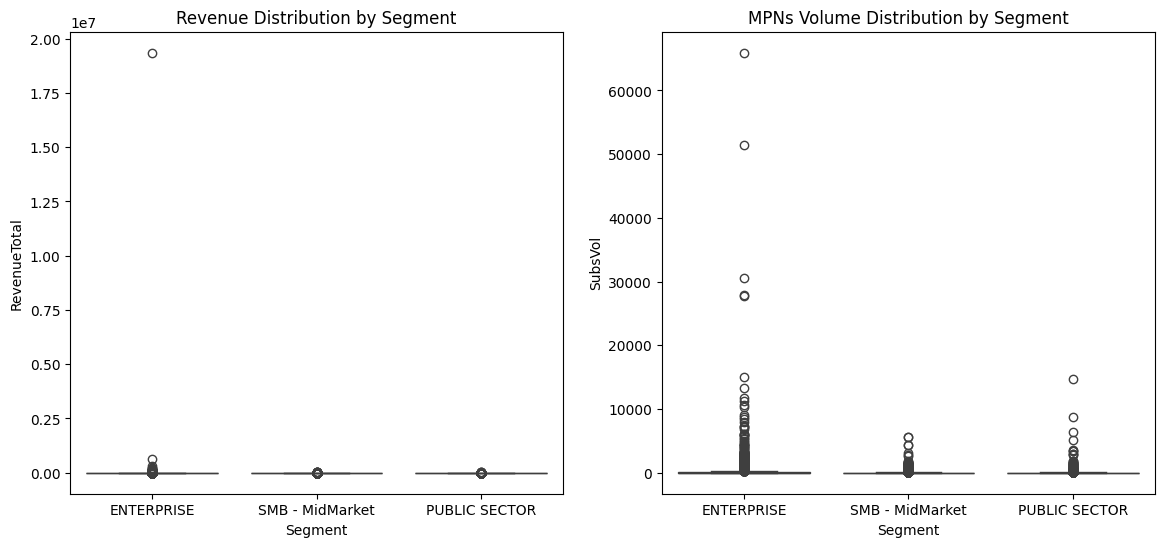

In [8]:
fig,axes=plt.subplots(1,2, figsize=(14,6))

sns.boxplot(df,x='Segment', y='RevenueTotal',ax=axes[0])
axes[0].set_title('Revenue Distribution by Segment')

sns.boxplot(df,x='Segment', y='SubsVol',ax=axes[1])
axes[1].set_title('MPNs Volume Distribution by Segment')

plt.show()

### !!! Apparently, there are outliers when it comes to Total volumes of revenue and MPNs, as the bigger the customer, the higher the volumes. The same expected for all other metrics.
I'll introduce new variables per MPN, to normalise our data

In [10]:
df['RevPerMPN']=df['RevenueTotal']/df['SubsVol']

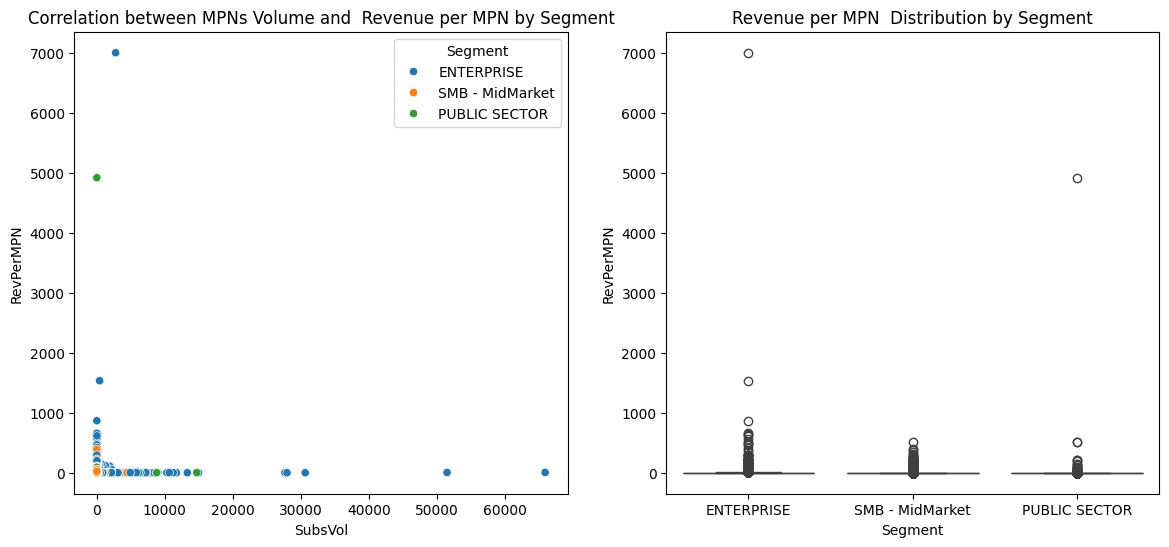

In [12]:
fig,axes=plt.subplots(1,2, figsize=(14,6))

sns.scatterplot(df,x='SubsVol', y='RevPerMPN', hue='Segment',ax=axes[0])
axes[0].set_title('Correlation between MPNs Volume and  Revenue per MPN by Segment')

sns.boxplot(df,x='Segment', y='RevPerMPN',ax=axes[1])
axes[1].set_title('Revenue per MPN  Distribution by Segment')

plt.show() 


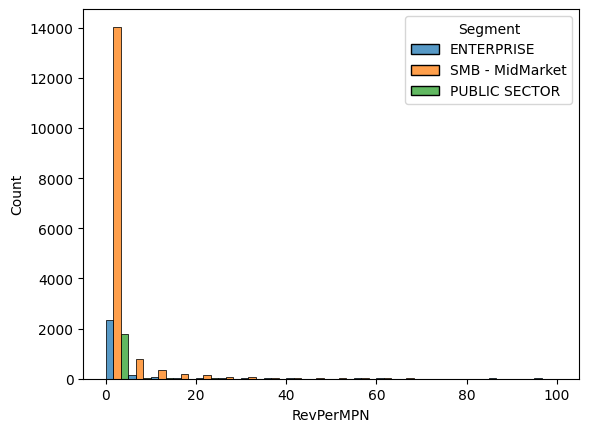

In [24]:
sns.histplot(df[df['RevPerMPN']<100],x='RevPerMPN', hue='Segment',bins=20,multiple = 'dodge')
plt.show()

### !!!! Revenue per MPN gives better distribution, however, there are still a lot of outliers. I'll fit the model with them and then remove the outliers by removing 95% percentiles.
Also, it's clear that MidMarket segment has different distribution

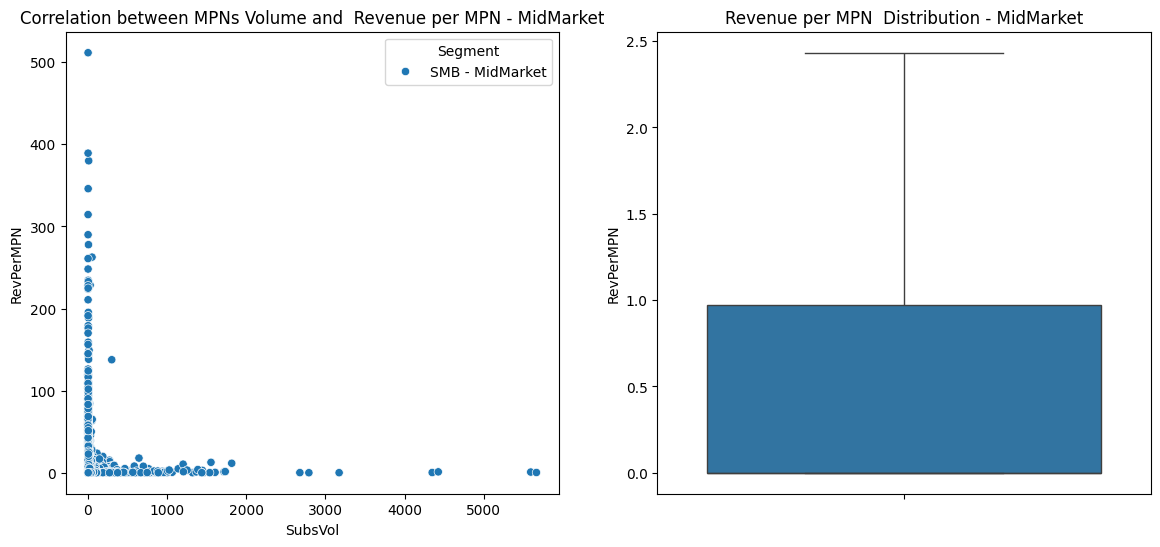

In [30]:
fig,axes=plt.subplots(1,2, figsize=(14,6))

sns.scatterplot(df[df['Segment']=='SMB - MidMarket'],x='SubsVol', y='RevPerMPN', hue='Segment',ax=axes[0])
axes[0].set_title('Correlation between MPNs Volume and  Revenue per MPN - MidMarket')

sns.boxplot(df[df['Segment']=='SMB - MidMarket'], y='RevPerMPN',ax=axes[1],showfliers=False)
axes[1].set_title('Revenue per MPN  Distribution - MidMarket')

plt.show() 

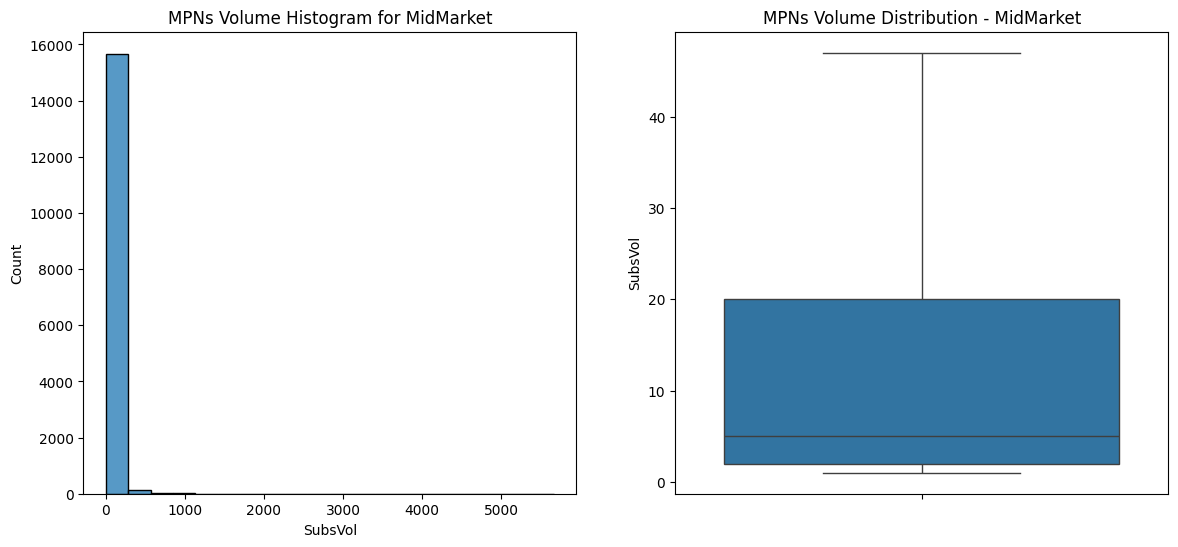

In [33]:
fig,axes=plt.subplots(1,2, figsize=(14,6))
sns.histplot(df[df['Segment']=='SMB - MidMarket'],x='SubsVol',bins=20,multiple = 'dodge',ax=axes[0])
axes[0].set_title('MPNs Volume Histogram for MidMarket')

sns.boxplot(df[df['Segment']=='SMB - MidMarket'], y='SubsVol',ax=axes[1],showfliers=False)
axes[1].set_title('MPNs Volume Distribution - MidMarket')
plt.show()

### !!! Another issue with Midmarket customers - the MPNs volume shout be below 100, otherwise, it's a wrong segmentation - the wrong customers should be removed from the dataset

In [38]:
df[(df['Segment']=='SMB - MidMarket') & (df['SubsVol']>100)].Satcode.count()

867

In [60]:
df_clean=df.copy()
df_clean=df_clean[
    (df_clean['Segment']!='SMB - MidMarket') |
    (df_clean['Segment']=='SMB - MidMarket') & (df_clean['SubsVol']<100)]
df_clean.shape

(19826, 12)

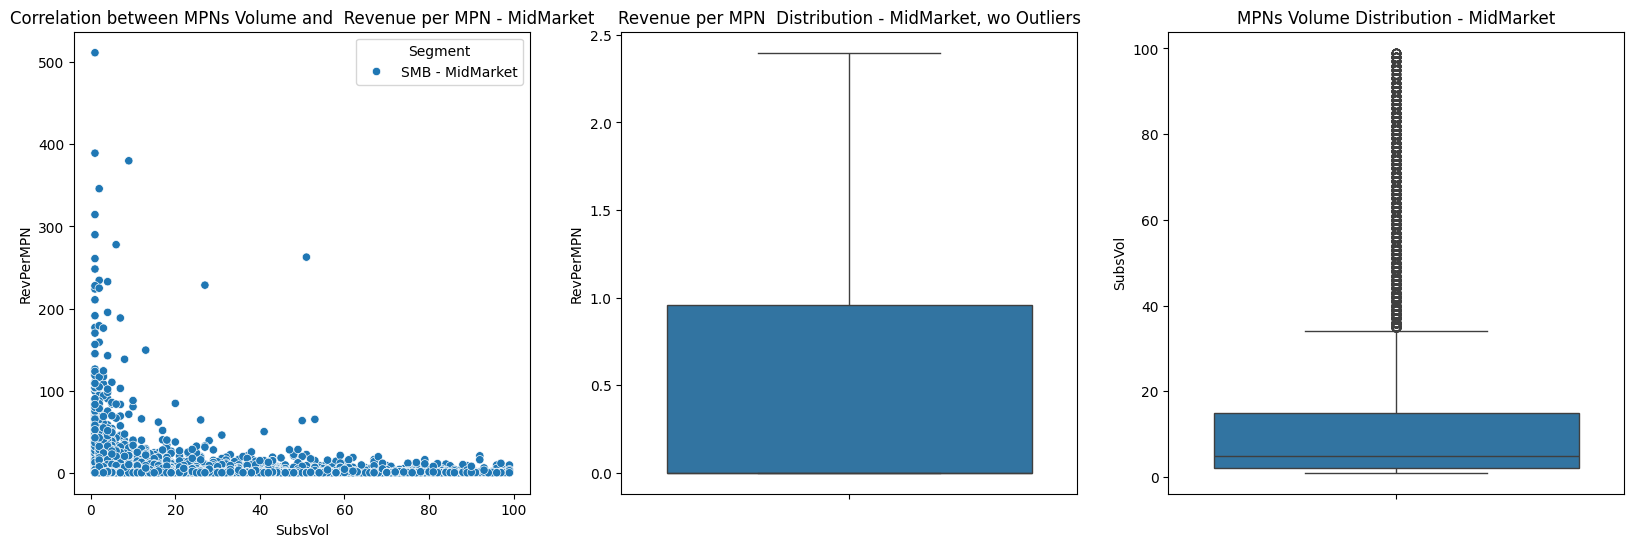

In [46]:
fig,axes=plt.subplots(1,3, figsize=(20,6))

sns.scatterplot(df_clean[df_clean['Segment']=='SMB - MidMarket'],x='SubsVol', y='RevPerMPN', hue='Segment',ax=axes[0])
axes[0].set_title('Correlation between MPNs Volume and  Revenue per MPN - MidMarket')

sns.boxplot(df_clean[df_clean['Segment']=='SMB - MidMarket'], y='RevPerMPN',ax=axes[1],showfliers=False)
axes[1].set_title('Revenue per MPN  Distribution - MidMarket, wo Outliers')

sns.boxplot(df_clean[df_clean['Segment']=='SMB - MidMarket'], y='SubsVol',ax=axes[2])
axes[2].set_title('MPNs Volume Distribution - MidMarket')
plt.show() 

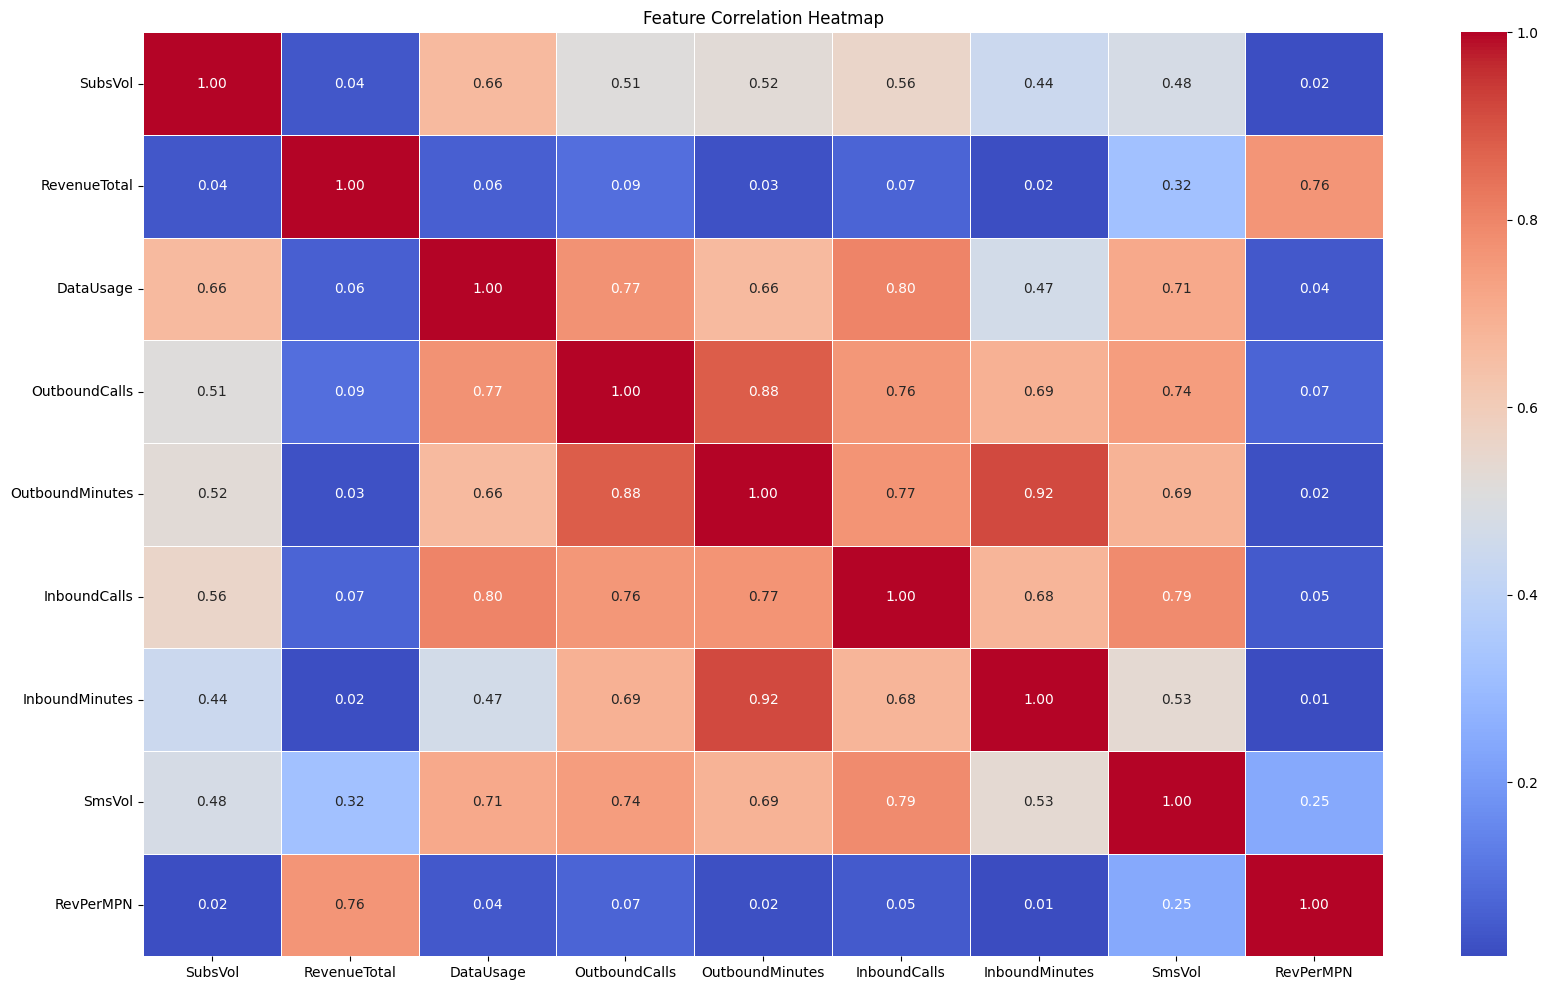

In [47]:
correlation_matrix = df_clean.corr()

plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Feature Correlation Heatmap")
plt.show()

### There're many correlated pairs, but it indicates that if subscribers have a high volume of Inbound Calls, then they have a high volume of other type of usage: Outbound calls, Data, SMS. Let's check if we observe it in clusters

# 2. Data Preparation

In [61]:
# applying One-hot encoding
df_clean=pd.get_dummies(df_clean,columns=['Segment','RoamingZone'],drop_first=True) #reducing dimensions to avoid multicollienarity
df_clean

,Satcode,SubsVol,RevenueTotal,DataUsage,OutboundCalls,OutboundMinutes,InboundCalls,InboundMinutes,SmsVol,RevPerMPN,Segment_PUBLIC SECTOR,Segment_SMB - MidMarket,RoamingZone_Zone 1 Europe,RoamingZone_Zone 2 North America,RoamingZone_Zone 3 Value,RoamingZone_Zone 4 Standard,RoamingZone_Zone 5 Premium
0,DG_CORINS,108,60.95,63170.444,576.0,113236.0,515.0,41189.0,176.0,0.564352,0,0,1,0,0,0,0
1,DG_PFWHIT,65,0.79,300044.253,448.0,45512.0,668.0,28093.0,92.0,0.012154,0,1,1,0,0,0,0
2,DG_STONPL,13,1.20,49976.262,225.0,40171.0,176.0,13947.0,29.0,0.092308,0,1,1,0,0,0,0
3,DG_BUNZL,396,524.08,261443.577,1058.0,255303.0,641.0,116376.0,983.0,1.323434,0,0,0,0,1,0,0
5,DG_ABDC,83,215.81,263152.739,761.0,132147.0,745.0,113397.0,89.0,2.600120,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20707,DG_WOMA,1,0.00,1078.268,30.0,6625.0,9.0,3292.0,1.0,0.000000,0,1,0,0,1,0,0
20708,DG_ZETAG,38,0.00,128806.549,30.0,3504.0,81.0,2013.0,30.0,0.000000,0,1,1,0,0,0,0
20709,DG_SCAPE,15,0.00,22038.263,30.0,3757.0,50.0,2512.0,8.0,0.000000,0,1,1,0,0,0,0
20710,DG_WESGL,3,0.00,4512.608,30.0,4582.0,27.0,1896.0,0.0,0.000000,0,1,1,0,0,0,0


In [65]:
# normalising the numerical variables
dfen=df_clean.copy()
col=['SubsVol', 'RevenueTotal', 'DataUsage', 'OutboundCalls','OutboundMinutes', 'InboundCalls', 'InboundMinutes', 'SmsVol', 'RevPerMPN']
scaler = StandardScaler()
dfen[col] = scaler.fit_transform(dfen[col])
dfen

,Satcode,SubsVol,RevenueTotal,DataUsage,OutboundCalls,OutboundMinutes,InboundCalls,InboundMinutes,SmsVol,RevPerMPN,Segment_PUBLIC SECTOR,Segment_SMB - MidMarket,RoamingZone_Zone 1 Europe,RoamingZone_Zone 2 North America,RoamingZone_Zone 3 Value,RoamingZone_Zone 4 Standard,RoamingZone_Zone 5 Premium
0,DG_CORINS,0.057540,-0.009059,0.038463,0.304253,0.317103,0.265857,0.174983,0.272159,-0.065890,0,0,1,0,0,0,0
1,DG_PFWHIT,0.003053,-0.009496,0.555208,0.211493,0.063734,0.379533,0.095310,0.066186,-0.074279,0,1,1,0,0,0,0
2,DG_STONPL,-0.062837,-0.009493,0.009680,0.049887,0.043753,0.013988,0.009249,-0.088294,-0.073061,0,1,1,0,0,0,0
3,DG_BUNZL,0.422471,-0.005693,0.471000,0.653553,0.848602,0.359473,0.632405,2.250973,-0.054357,0,0,0,0,1,0,0
5,DG_ABDC,0.025862,-0.007934,0.474729,0.438320,0.387852,0.436742,0.614282,0.058829,-0.034961,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20707,DG_WOMA,-0.078043,-0.009502,-0.096992,-0.091427,-0.081749,-0.110089,-0.055574,-0.156952,-0.074464,0,1,0,0,1,0,0
20708,DG_ZETAG,-0.031159,-0.009502,0.181650,-0.091427,-0.093425,-0.056595,-0.063355,-0.085842,-0.074464,0,1,1,0,0,0,0
20709,DG_SCAPE,-0.060303,-0.009502,-0.051267,-0.091427,-0.092479,-0.079627,-0.060319,-0.139788,-0.074464,0,1,1,0,0,0,0
20710,DG_WESGL,-0.075508,-0.009502,-0.089500,-0.091427,-0.089392,-0.096715,-0.064067,-0.159404,-0.074464,0,1,1,0,0,0,0


In [66]:
# let's drop  satcode
dfen=dfen.drop('Satcode', axis=1)


## 3.Fitting the model

#### 3.1 With RevenueTotal

In [149]:
# first let's run the model for the original set of columns with RevenueTotal, not RevPerMPN
dfs=dfen.drop('RevPerMPN',axis=1)
kmeans = KMeans(n_clusters=6, random_state=1)
dfs['Cluster'] = kmeans.fit_predict(dfs)
print(f'Inertia: {kmeans.inertia_}')
centroids = kmeans.cluster_centers_

# Создадим DataFrame для центроидов с колонками, которые соответствуют вашим признакам:
centroids_df = pd.DataFrame(centroids, columns=dfs.columns)

print('-----------Centroids---------------')
print(centroids_df)

# Определим самые сильные факторы для каждого кластера
feature_importance = centroids_df.abs().max(axis=0)
print('-----------Feature Importance---------------')
print(feature_importance.sort_values(ascending=False))


Inertia: 51585.11138431245
-----------Centroids---------------
     SubsVol  RevenueTotal  DataUsage  OutboundCalls  OutboundMinutes  \
0  -0.040736     -0.007565  -0.048064      -0.048323        -0.047162   
1  16.682071      0.111564  32.260950      27.217211        19.128351   
2   3.425553    140.641760   7.523834      12.298565         3.512416   
3   4.038773      0.034935   5.111661       5.481398         5.748936   
4  74.316667      1.710358  15.348864       1.200330         1.114615   
5  35.364663     -0.009374  18.688712      56.695854        93.980229   

   InboundCalls  InboundMinutes     SmsVol  Segment_PUBLIC SECTOR  \
0     -0.051209       -0.033791  -0.054397               0.096696   
1     28.998652       11.948651  24.429878               0.100000   
2      9.262571        2.491910  44.397022               0.000000   
3      5.943778        3.845847   6.765750               0.099099   
4      0.295205        0.415114   1.293443               0.000000   
5     49.26

/Users/andreyakimov/opt/miniconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [156]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(dfs.drop('Cluster',axis=1), dfs['Cluster'])

# Получаем важность признаков
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame(importances, index=dfs.drop('Cluster',axis=1).columns, columns=['Importance'])

# Печатаем важность признаков
print(feature_importance_df.sort_values(by='Importance', ascending=False))

                                  Importance
OutboundCalls                       0.223957
DataUsage                           0.163795
OutboundMinutes                     0.155190
InboundCalls                        0.147131
SubsVol                             0.135982
SmsVol                              0.077587
InboundMinutes                      0.067986
RevenueTotal                        0.017890
RoamingZone_Zone 3 Value            0.003233
RoamingZone_Zone 1 Europe           0.002208
Segment_SMB - MidMarket             0.001944
Segment_PUBLIC SECTOR               0.001562
RoamingZone_Zone 2 North America    0.001354
RoamingZone_Zone 5 Premium          0.000126
RoamingZone_Zone 4 Standard         0.000056


In [151]:
# get the cluster sizes
dfs.groupby('Cluster').size()

Cluster
0    19701
1       10
2        1
3      111
4        2
5        1
dtype: int64

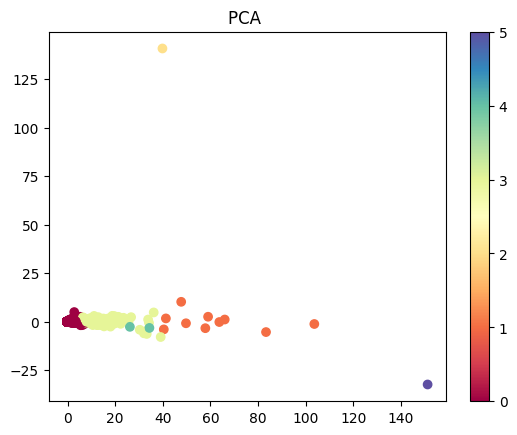

[0.56350176 0.12107573 0.08457397 0.05660997 0.03194729 0.02783604
 0.02557172 0.02280435 0.02052949 0.01439908]


In [152]:
pca = PCA(n_components=10)  
X_pca = pca.fit_transform(dfs.drop('Cluster',axis=1))

# Визуализируем
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='Spectral')
plt.colorbar()
plt.title('PCA ')
plt.show()

print(pca.explained_variance_ratio_)

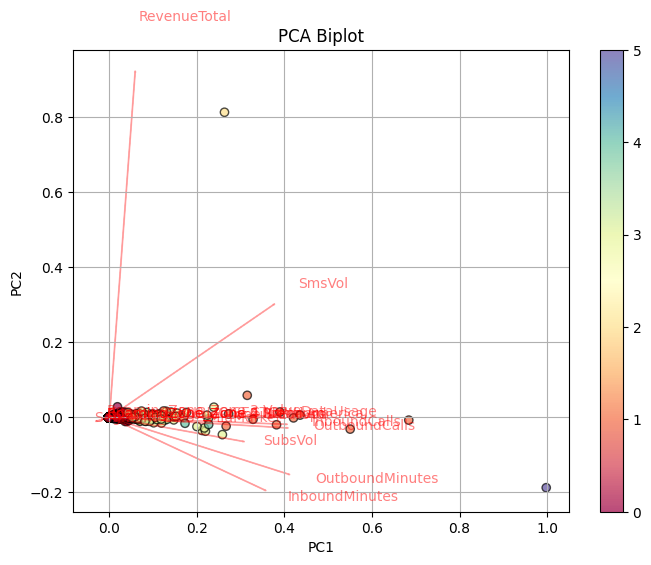

In [154]:
def biplot(score, coeff, labels=None, target='b'):
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]

    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())

    plt.figure(figsize=(8, 6))
    plt.scatter(xs * scalex, ys * scaley, c=target, cmap='Spectral', edgecolor='k', alpha=0.7)
    
    for i in range(n):
        plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='r', alpha=0.3)
        plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, labels[i], color='r', fontsize=10,alpha=0.5)

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA Biplot")
    plt.colorbar()
    plt.grid()

# Call the biplot function
biplot(X_pca, pca.components_.T, labels=feature_importance_df.index,target=kmeans.labels_)
plt.show()

In [155]:
dfs

,SubsVol,RevenueTotal,DataUsage,OutboundCalls,OutboundMinutes,InboundCalls,InboundMinutes,SmsVol,Segment_PUBLIC SECTOR,Segment_SMB - MidMarket,RoamingZone_Zone 1 Europe,RoamingZone_Zone 2 North America,RoamingZone_Zone 3 Value,RoamingZone_Zone 4 Standard,RoamingZone_Zone 5 Premium,Cluster
0,0.057540,-0.009059,0.038463,0.304253,0.317103,0.265857,0.174983,0.272159,0,0,1,0,0,0,0,0
1,0.003053,-0.009496,0.555208,0.211493,0.063734,0.379533,0.095310,0.066186,0,1,1,0,0,0,0,0
2,-0.062837,-0.009493,0.009680,0.049887,0.043753,0.013988,0.009249,-0.088294,0,1,1,0,0,0,0,0
3,0.422471,-0.005693,0.471000,0.653553,0.848602,0.359473,0.632405,2.250973,0,0,0,0,1,0,0,0
5,0.025862,-0.007934,0.474729,0.438320,0.387852,0.436742,0.614282,0.058829,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20707,-0.078043,-0.009502,-0.096992,-0.091427,-0.081749,-0.110089,-0.055574,-0.156952,0,1,0,0,1,0,0,0
20708,-0.031159,-0.009502,0.181650,-0.091427,-0.093425,-0.056595,-0.063355,-0.085842,0,1,1,0,0,0,0,0
20709,-0.060303,-0.009502,-0.051267,-0.091427,-0.092479,-0.079627,-0.060319,-0.139788,0,1,1,0,0,0,0,0
20710,-0.075508,-0.009502,-0.089500,-0.091427,-0.089392,-0.096715,-0.064067,-0.159404,0,1,1,0,0,0,0,0


#### 3.2 Fitting with RevPerMPN

In [184]:
# first let's run the model for the original set of columns with RevenueTotal, not RevPerMPN
dfs=dfen[dfen['Segment_SMB - MidMarket']==1].drop('RevenueTotal',axis=1)
kmeans = KMeans(n_clusters=4, random_state=1,n_init=10)
dfs['Cluster'] = kmeans.fit_predict(dfs)
print(f'Inertia: {kmeans.inertia_}')
centroids = kmeans.cluster_centers_

# Создадим DataFrame для центроидов с колонками, которые соответствуют вашим признакам:
centroids_df = pd.DataFrame(centroids, columns=dfs.columns)

print('-----------Centroids---------------')
print(centroids_df)

# Определим самые сильные факторы для каждого кластера
feature_importance = centroids_df.abs().max(axis=0)
print('-----------Feature Importance---------------')
print(feature_importance.sort_values(ascending=False))

Inertia: 4195.834193754457
-----------Centroids---------------
    SubsVol  DataUsage  OutboundCalls  OutboundMinutes  InboundCalls  \
0 -0.064321  -0.085707      -0.085597        -0.075312     -0.103601   
1 -0.048120  -0.020394      -0.010185        -0.025744      0.013024   
2 -0.069098  -0.084238      -0.087814        -0.083107     -0.100586   
3 -0.075435  -0.098095      -0.108900        -0.102587     -0.115113   

   InboundMinutes    SmsVol  RevPerMPN  Segment_PUBLIC SECTOR  \
0       -0.056684 -0.101558  -0.037093                    0.0   
1        0.000947 -0.032110  -0.064160                    0.0   
2       -0.061516 -0.110731  -0.033733                    0.0   
3       -0.073136 -0.148843   0.027365                    0.0   

   Segment_SMB - MidMarket  RoamingZone_Zone 1 Europe  \
0                      1.0              -2.220446e-15   
1                      1.0               9.997819e-01   
2                      1.0               9.436896e-16   
3                     

In [185]:
# get the cluster sizes
dfs.groupby('Cluster').size()

Cluster
0    3962
1    4586
2    2700
3    3754
dtype: int64

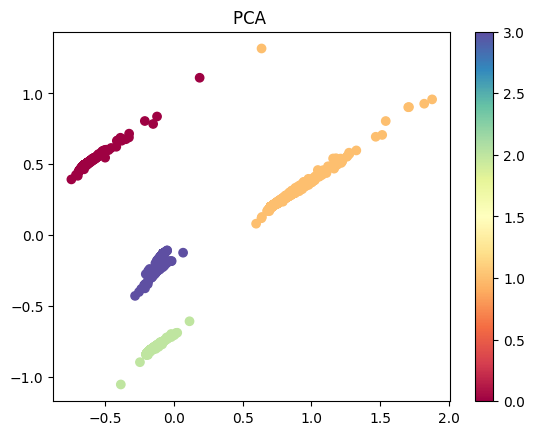

[0.32638039 0.23565094 0.14413808 0.10647587 0.07365395 0.04779249
 0.03204906 0.01203421 0.01015594 0.00586841]


In [186]:
pca = PCA(n_components=10)  
X_pca = pca.fit_transform(dfs.drop('Cluster',axis=1))


plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='Spectral')
plt.colorbar()
plt.title('PCA ')
plt.show()

print(pca.explained_variance_ratio_)

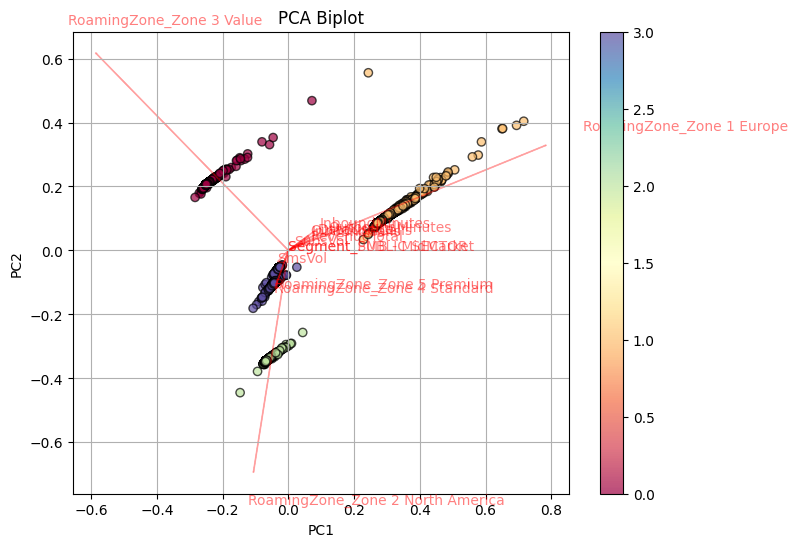

In [187]:
biplot(X_pca, pca.components_.T, labels=feature_importance_df.index,target=kmeans.labels_)
plt.show()

In [188]:
dfs[dfs['Cluster']==5]

,SubsVol,DataUsage,OutboundCalls,OutboundMinutes,InboundCalls,InboundMinutes,SmsVol,RevPerMPN,Segment_PUBLIC SECTOR,Segment_SMB - MidMarket,RoamingZone_Zone 1 Europe,RoamingZone_Zone 2 North America,RoamingZone_Zone 3 Value,RoamingZone_Zone 4 Standard,RoamingZone_Zone 5 Premium,Cluster


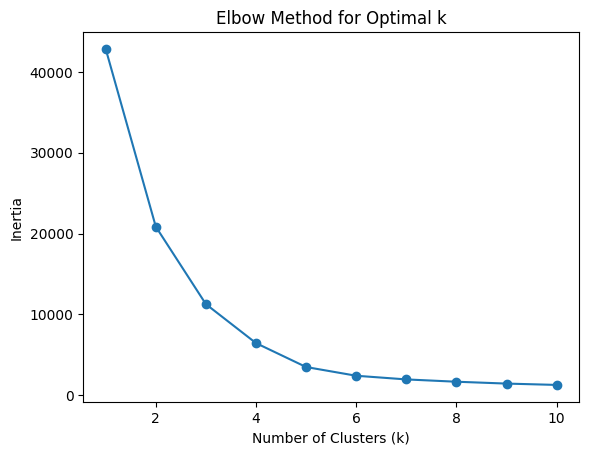

In [183]:
inertia_values = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1,n_init=10)
    kmeans.fit(dfs)
    inertia_values.append(kmeans.inertia_)

# Построим график инерции
plt.plot(range(1, 11), inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [189]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(dfs.drop('Cluster',axis=1), dfs['Cluster'])

# Получаем важность признаков
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame(importances, index=dfs.drop('Cluster',axis=1).columns, columns=['Importance'])

# Печатаем важность признаков
print(feature_importance_df.sort_values(by='Importance', ascending=False))

                                  Importance
RoamingZone_Zone 3 Value            0.288018
RoamingZone_Zone 1 Europe           0.227575
RoamingZone_Zone 2 North America    0.212966
InboundCalls                        0.074451
DataUsage                           0.043098
RoamingZone_Zone 4 Standard         0.042055
RoamingZone_Zone 5 Premium          0.033856
RevPerMPN                           0.020405
SubsVol                             0.017937
InboundMinutes                      0.015518
OutboundCalls                       0.011590
OutboundMinutes                     0.009034
SmsVol                              0.003497
Segment_PUBLIC SECTOR               0.000000
Segment_SMB - MidMarket             0.000000
